In [244]:
import pandas as pd

# データ取得
from policy_analysis.table_generate.master_manager import BQMasterManager
from policy_analysis.table_generate.query_config import InfoCollector
from policy_analysis.table_generate.query_builder import QueryBuilder
from policy_analysis.table_generate.table_generator import BQTableGenerator

# 検定・可視化
from policy_analysis.result_visualize.visualize_config import MeanValue, PropValue, VisualizeInfo, convert_mean_value
from policy_analysis.result_visualize.summary_visualizer import SummaryVisualizer
from policy_analysis.result_visualize.timeseries_visualizer import TimeSeriesVisualizer

pd.options.display.float_format = '{:.3f}'.format

# 各日付で、広告の比較

In [456]:
from policy_analysis.result_visualize.bucketeer_allocation_ratio_scaler import BucketeerAllocationRatioScaler

df = pd.read_csv('data/ad.csv')
scale_columns = ['cue_cnt', 'cue_vod_cnt',
       'cue_linear_cnt', 'cue_live_event_cnt', 'imp_cm_cnt', 'imp_ad_cnt',
       'imp_vod_cm_cnt', 'imp_vod_ad_cnt', 'imp_linear_cm_cnt',
       'imp_linear_ad_cnt', 'imp_live_event_cm_cnt', 'imp_live_event_ad_cnt']

# 対象のカラムはfloatに変換
df[scale_columns] = df[scale_columns].astype(float)
scaler = BucketeerAllocationRatioScaler({'vod_landing': 0.276, 'linear_landing': 1})
df = scaler.scaling(df, scale_target_columns=scale_columns)


2024-07-01 03:40:39,734 policy_analysis.result_visualize.bucketeer_allocation_ratio_scaler _cal_scale [INFO]: variation_id: vod_landing, 割り当て比率: 0.276, 3.623倍にカラムをスケールします。
2024-07-01 03:40:39,735 policy_analysis.result_visualize.bucketeer_allocation_ratio_scaler _cal_scale [INFO]: variation_id: linear_landing, 割り当て比率: 1.0, 1.0倍にカラムをスケールします。


In [457]:
import plotly.express as px

start_dt = '2024-03-14'
end_dt = '2024-03-25'

# variation_idでの差分を各指標で取得して、棒グラフで可視化
_diff = df.query('dt >= "2024-03-14" & dt <= "2024-03-25"')[['dt', 'variation_id'] + ['imp_ad_cnt']].groupby(['dt', 'variation_id']).sum().unstack().diff(axis=1).fillna(0)
# _diff = df[['dt', 'variation_id'] + ['imp_ad_cnt']].groupby(['dt', 'variation_id']).sum().unstack().diff(axis=1).fillna(0)
_diff.columns = _diff.columns.droplevel()
_diff = _diff.reset_index()
_diff = _diff.melt(id_vars=['dt'], var_name='variation_id', value_name='diff')
_diff['variation_id'] = _diff['variation_id'].astype(str)
_diff['round'] = _diff['diff'].round(1)
_diff['color'] = _diff['diff'] > 0
fig = px.bar(_diff, x='dt', y='diff', color='color', text = 'round', title='広告imp回数の差分(ビデオランディング:True - リニアランディング:False)', labels={'diff': '差分', 'dt': '日付'})
# start_dt, end_dtを薄いピンクで囲う
fig.add_vrect(x0=start_dt, x1=end_dt, fillcolor="pink", opacity=0.5, layer="below", line_width=0)
fig.show()


# 各日付で、広告impに差を出したシリーズを特定する

## データ加工 

In [413]:
from policy_analysis.result_visualize.bucketeer_allocation_ratio_scaler import BucketeerAllocationRatioScaler

watch_df = pd.read_csv('data/series_watch.csv')
watch_df.sort_values(['dt', 'variation_id'], inplace=True)
ad_df = pd.read_csv('data/series_ad.csv')
ad_df.sort_values(['dt', 'variation_id'], inplace=True)

# dt, device, variation_id, series_idで結合する
# 広告も視聴もないようなシリーズは除くために inner join する
df = pd.merge(watch_df, ad_df, on=['dt', 'device', 'variation_id', 'series_id', 'series_name'], how='inner')

scale_columns = ['dau', 'elapsed_hour', 'elapsed_vod_hour', 'elapsed_linear_hour',
       'elapsed_live_event_hour', 'watch_0sec_uu', 'watch_10sec_uu',
       'watch_5min_uu', 'watch_vod_0sec_uu', 'watch_vod_10sec_uu',
       'watch_vod_5min_uu', 'watch_linear_0sec_uu', 'watch_linear_10sec_uu',
       'watch_linear_5min_uu', 'watch_live_event_0sec_uu',
       'watch_live_event_10sec_uu', 'watch_live_event_5min_uu',
       'watch_10sec_cnt', 'watch_5min_cnt', 'watch_vod_10sec_cnt',
       'watch_vod_5min_cnt', 'watch_linear_10sec_cnt', 'watch_linear_5min_cnt',
       'watch_live_event_10sec_cnt', 'watch_live_event_5min_cnt',
       'cue_cnt', 'cue_vod_cnt', 'cue_linear_cnt', 'cue_live_event_cnt',
       'imp_cm_cnt', 'imp_ad_cnt', 'imp_vod_cm_cnt', 'imp_vod_ad_cnt',
       'imp_linear_cm_cnt', 'imp_linear_ad_cnt', 'imp_live_event_cm_cnt',
       'imp_live_event_ad_cnt']

# 対象のカラムはfloatに変換
df[scale_columns] = df[scale_columns].astype(float)
scaler = BucketeerAllocationRatioScaler({'vod_landing': 0.272, 'linear_landing': 1})
df = scaler.scaling(df, scale_target_columns=scale_columns)

df.to_csv('data/series_merge.csv', index=False)

2024-07-01 03:08:13,825 policy_analysis.result_visualize.bucketeer_allocation_ratio_scaler _cal_scale [INFO]: variation_id: vod_landing, 割り当て比率: 0.272, 3.676倍にカラムをスケールします。
2024-07-01 03:08:13,825 policy_analysis.result_visualize.bucketeer_allocation_ratio_scaler _cal_scale [INFO]: variation_id: linear_landing, 割り当て比率: 1.0, 1.0倍にカラムをスケールします。


In [414]:
# dt, variation_idごとにdauを集計
df[['dt', 'variation_id', 'dau']].drop_duplicates()

,dt,variation_id,dau
0,2024-03-16,linear_landing,81713.000
900,2024-03-16,vod_landing,74178.004
1563,2024-03-17,linear_landing,104594.000
2487,2024-03-17,vod_landing,94877.560
3147,2024-03-20,linear_landing,137488.000
4080,2024-03-20,vod_landing,124193.660
4741,2024-03-22,linear_landing,72672.000
5629,2024-03-22,vod_landing,65815.104


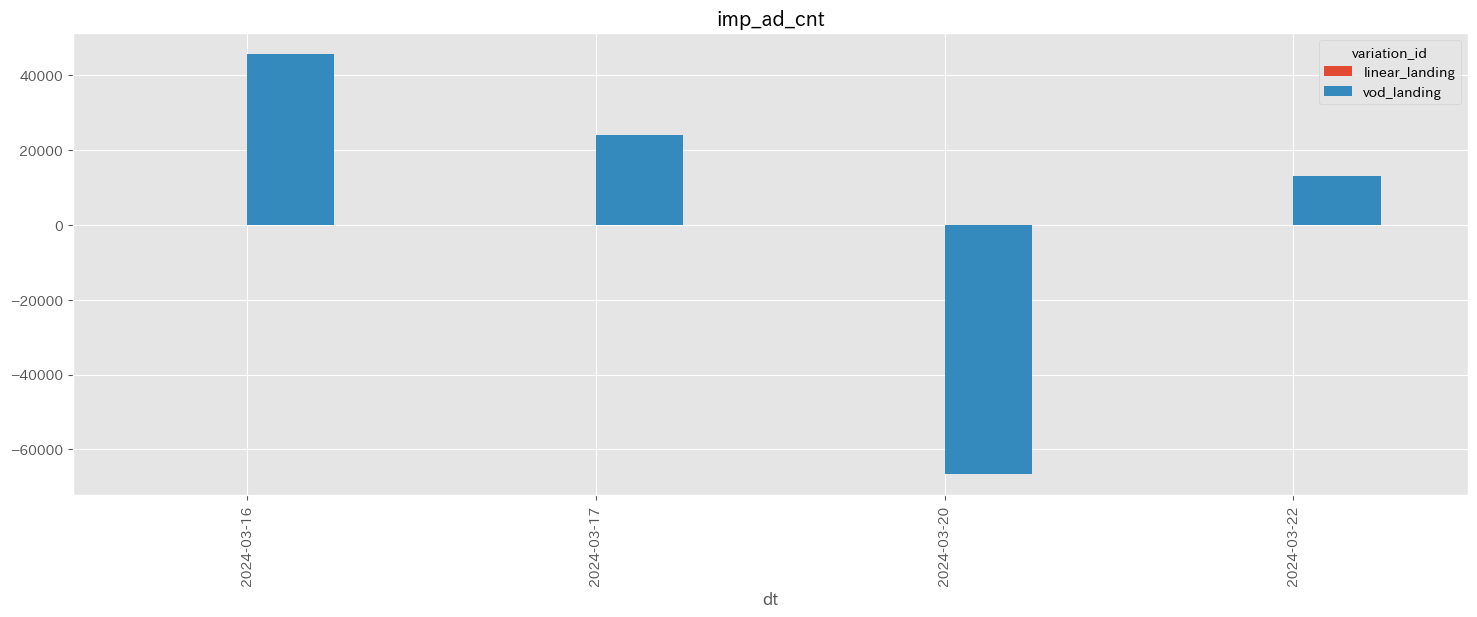

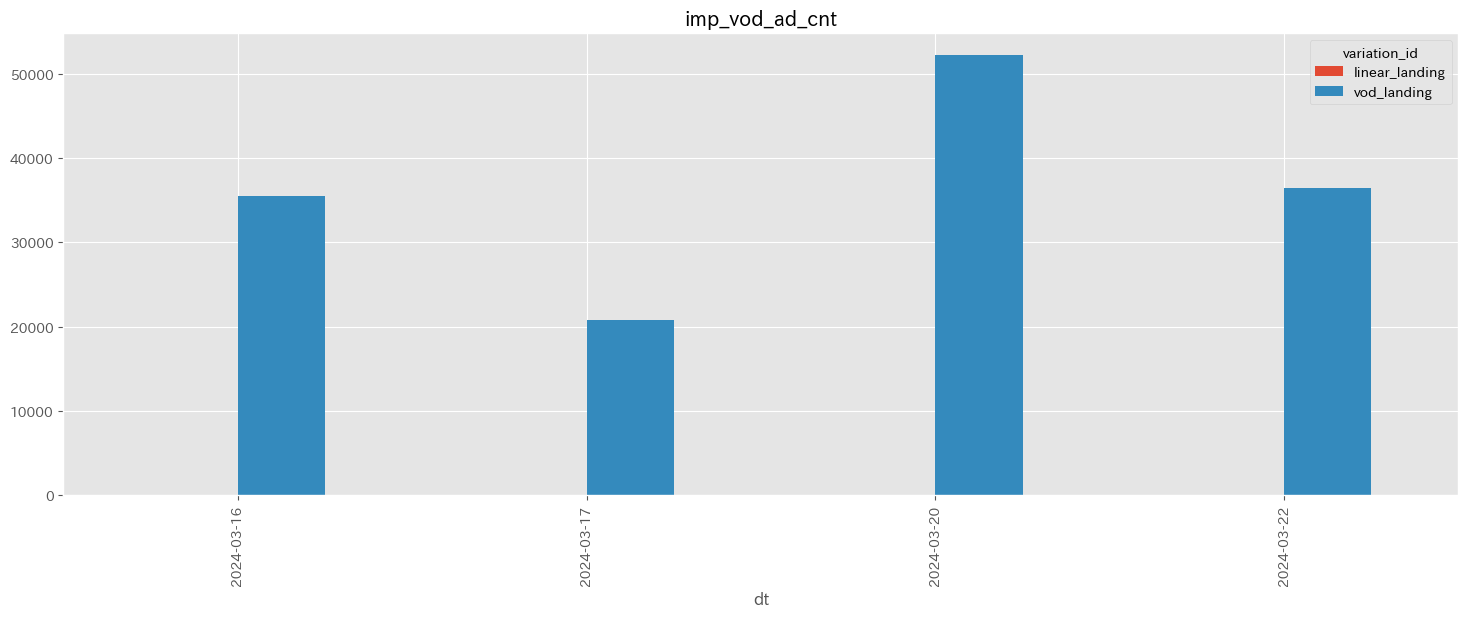

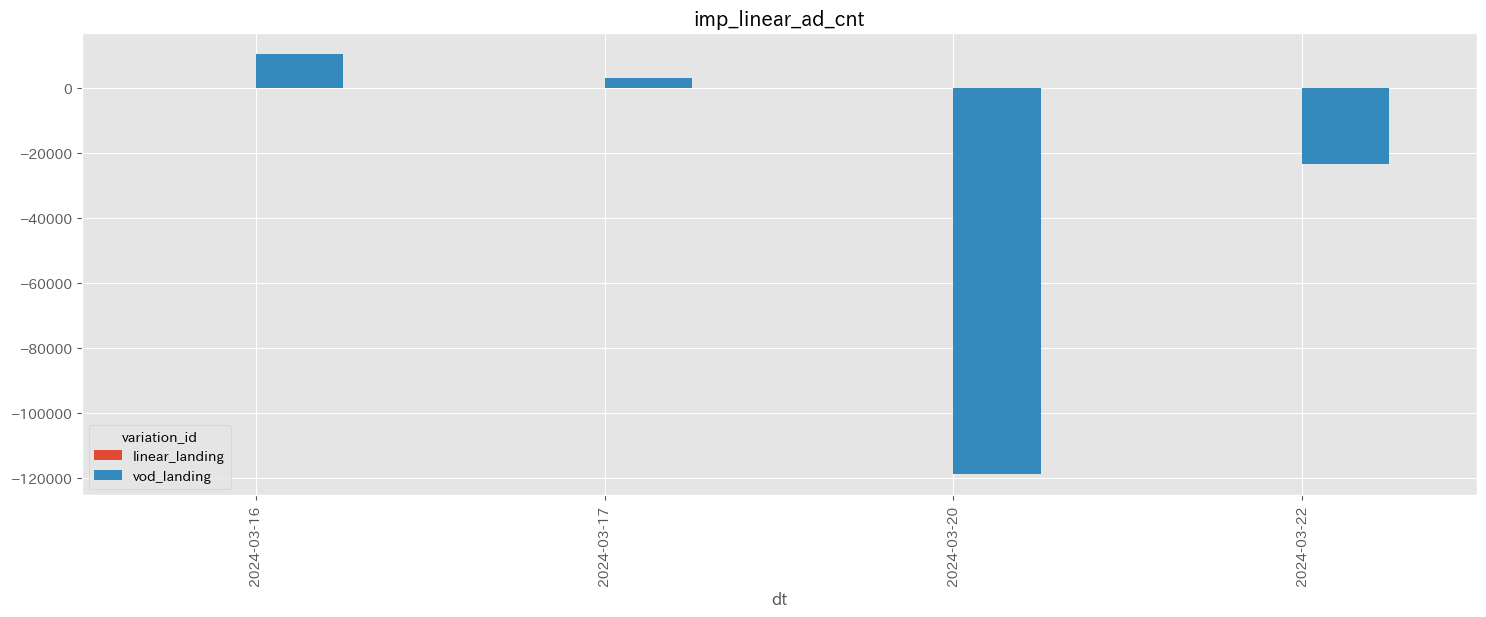

In [415]:
# dt, variationごとに imp_ad_cnt, imp_vod_ad_cnt, imp_linear_ad_cntを合算する
columns = ['imp_ad_cnt', 'imp_vod_ad_cnt', 'imp_linear_ad_cnt']
_df = df.groupby(['dt', 'variation_id'])[columns].sum().reset_index()

for column in columns:
    # 日付ごとにvariation_id間の差分を棒グラフで表示
    _df = df.groupby(['dt', 'variation_id'])[column].sum().reset_index()
    _df = _df.pivot(index='dt', columns='variation_id', values=column)
    _diff = _df.diff(axis=1)
    _diff.plot.bar(title=column)

## 各日付での差分

In [416]:
import pandas as pd
import plotly.express as px

def plot_ad_imp_diff(df, target_date, x_column, y_column, variation_vod='vod_landing', variation_linear='linear_landing', w=1000, h=1000):
    columns = ['series_name', x_column, y_column]
    
    vod_df = df.query('dt == @target_date and variation_id == @variation_vod')[columns].set_index('series_name')
    linear_df = df.query('dt == @target_date and variation_id == @variation_linear')[columns].set_index('series_name')
    
    x_df = pd.merge(vod_df[x_column], linear_df[x_column], on='series_name', how='outer', suffixes=('_vod', '_linear'))
    x_df.fillna(0, inplace=True)
    x_df[x_column] = x_df[x_column + '_vod'] - x_df[x_column + '_linear']
    
    y_df = pd.merge(vod_df[y_column], linear_df[y_column], on='series_name', how='outer', suffixes=('_vod', '_linear'))
    y_df.fillna(0, inplace=True)
    y_df[y_column] = y_df[y_column + '_vod'] - y_df[y_column + '_linear']
    
    _df = pd.merge(x_df, y_df, on='series_name', how='outer')
    
    _df['sum'] = (_df[x_column] + _df[y_column]).round(0)
    _df.sort_values('sum', inplace=True)
    _df['color'] = _df['sum'].apply(lambda x: 'vod_landing' if x > 0 else 'linear_landing')
    _df['text'] = _df.apply(lambda x: '' if abs(x['sum']) < 3000 else x.name + ': ' + str(x['sum']), axis=1)
    
    fig = px.scatter(_df, x=x_column, y=y_column, text='text', color='color')
    fig.update_traces(textposition='top center')
    fig.update_layout(
        title=f'{target_date} シリーズごとの広告imp数の差分(横:ビデオのimp, 縦:リニアのimp)',
        xaxis_title=x_column,
        yaxis_title=y_column,
        height=h,
        width=w
    )
    fig.show()

In [417]:
# ビデオランディングが勝った日
plot_ad_imp_diff(df, '2024-03-16', 'imp_vod_ad_cnt', 'imp_linear_ad_cnt')
plot_ad_imp_diff(df, '2024-03-17', 'imp_vod_ad_cnt', 'imp_linear_ad_cnt')
# plot_ad_imp_diff(df, '2024-03-27', 'imp_vod_ad_cnt', 'imp_linear_ad_cnt')
# plot_ad_imp_diff(df, '2024-03-31', 'imp_vod_ad_cnt', 'imp_linear_ad_cnt')

# ビデオランディングが勝った日
# plot_ad_imp_diff(df, '2024-03-16', 'watch_vod_10sec_uu', 'watch_linear_10sec_uu')
# plot_ad_imp_diff(df, '2024-03-17', 'watch_vod_10sec_uu', 'watch_linear_10sec_uu')
# plot_ad_imp_diff(df, '2024-03-27', 'watch_vod_10sec_uu', 'watch_linear_10sec_uu')
# plot_ad_imp_diff(df, '2024-03-31', 'watch_vod_10sec_uu', 'watch_linear_10sec_uu')

In [418]:
# リニアランディングが勝った日
plot_ad_imp_diff(df, '2024-03-20', 'imp_vod_ad_cnt', 'imp_linear_ad_cnt')
plot_ad_imp_diff(df, '2024-03-22', 'imp_vod_ad_cnt', 'imp_linear_ad_cnt')
# plot_ad_imp_diff(df, '2024-03-28', 'imp_vod_ad_cnt', 'imp_linear_ad_cnt')
# plot_ad_imp_diff(df, '2024-03-29', 'imp_vod_ad_cnt', 'imp_linear_ad_cnt')

# リニアランディングが勝った日
# plot_ad_imp_diff(df, '2024-03-20', 'watch_vod_10sec_uu', 'watch_linear_10sec_uu')
# plot_ad_imp_diff(df, '2024-03-22', 'watch_vod_10sec_uu', 'watch_linear_10sec_uu')
# plot_ad_imp_diff(df, '2024-03-28', 'watch_vod_10sec_uu', 'watch_linear_10sec_uu')
# plot_ad_imp_diff(df, '2024-03-29', 'watch_vod_10sec_uu', 'watch_linear_10sec_uu')

In [423]:
import pandas as pd

def display_ad_imp_diff(df, target_date, x_column, y_column, variation_vod='vod_landing', variation_linear='linear_landing', w=1000, h=1000):
    columns = ['series_name', x_column, y_column]
    
    vod_df = df.query('dt == @target_date and variation_id == @variation_vod')[columns].set_index('series_name')
    linear_df = df.query('dt == @target_date and variation_id == @variation_linear')[columns].set_index('series_name')
    
    x_df = pd.merge(vod_df[x_column], linear_df[x_column], on='series_name', how='outer', suffixes=('_vod', '_linear'))
    x_df.fillna(0, inplace=True)
    x_df[x_column] = x_df[x_column + '_vod'] - x_df[x_column + '_linear']
    
    y_df = pd.merge(vod_df[y_column], linear_df[y_column], on='series_name', how='outer', suffixes=('_vod', '_linear'))
    y_df.fillna(0, inplace=True)
    y_df[y_column] = y_df[y_column + '_vod'] - y_df[y_column + '_linear']
    
    _df = pd.merge(x_df, y_df, on='series_name', how='outer')
    
    _df['sum'] = (_df[x_column] + _df[y_column]).round(0)
    _df['abs'] = _df['sum'].abs()
    _df.sort_values('abs', ascending=False, inplace=True)

    # intで表示
    display(_df[[x_column, y_column, 'sum', 'abs']].head(10).style.format('{:.0f}'))

In [424]:
# ビデオランディングが勝った日
display_ad_imp_diff(df, '2024-03-16', 'imp_vod_ad_cnt', 'imp_linear_ad_cnt')
display_ad_imp_diff(df, '2024-03-17', 'imp_vod_ad_cnt', 'imp_linear_ad_cnt')

,imp_vod_ad_cnt,imp_linear_ad_cnt,sum,abs
series_name,,,,
ABEMA NEWS 202402,-13,-23273,-23286,23286
CMチャンネル,0,-5400,-5400,5400
ドラゴンボール改,211,5050,5261,5261
薬屋のひとりごと,1201,3920,5120,5120
ソードアート・オンライン,427,4571,4998,4998
世界最高の暗殺者、異世界貴族に転生する,1251,3169,4420,4420
映画ドラえもん,0,3963,3963,3963
棋王戦,-61,-3036,-3097,3097
NewsBAR橋下,-92,-2982,-3074,3074


,imp_vod_ad_cnt,imp_linear_ad_cnt,sum,abs
series_name,,,,
ABEMA NEWS 202402,39,-13925,-13887,13887
棋王戦,28,9920,9948,9948
メジャーリーグベースボール2024,0,-9665,-9665,9665
薬屋のひとりごと,1607,7439,9046,9046
麻雀最強戦2024,5,9017,9022,9022
ABEMA的ニュースショー,-19,-5881,-5900,5900
ドラゴンボール改,1281,3551,4832,4832
RISE 2024,-258,4624,4366,4366
ABEMA大相撲 2024,27,4130,4157,4157


In [425]:
# ビデオランディングが勝った日
display_ad_imp_diff(df, '2024-03-20', 'imp_vod_ad_cnt', 'imp_linear_ad_cnt')
display_ad_imp_diff(df, '2024-03-22', 'imp_vod_ad_cnt', 'imp_linear_ad_cnt')

,imp_vod_ad_cnt,imp_linear_ad_cnt,sum,abs
series_name,,,,
メジャーリーグベースボール2024,-28,-92076,-92104,92104
ABEMA NEWS 202402,-46,-25112,-25158,25158
ABEMA Prime,42,-5772,-5730,5730
ペントハウス,-3372,-1146,-4518,4518
ドラゴンボール改,1098,3215,4313,4313
劇場版 転生したらスライムだった件 紅蓮の絆編,4257,0,4257,4257
盾の勇者の成り上がり,1656,1231,2886,2886
美味しんぼ,2131,731,2862,2862
藤田晋invitational RTDリーグ,0,2860,2860,2860


,imp_vod_ad_cnt,imp_linear_ad_cnt,sum,abs
series_name,,,,
ABEMA NEWS 202402,-30,-13428,-13458,13458
ポーション頼みで生き延びます！,-317,6919,6602,6602
映画クレヨンしんちゃん,2527,2735,5262,5262
王女ピョンガン 月が浮かぶ川,5091,17,5108,5108
CMチャンネル,0,-5075,-5075,5075
ABEMA Prime,85,-5060,-4975,4975
王座戦,7,-4789,-4782,4782
今日、好きになりました。2023,-2948,-543,-3491,3491
ドラゴンボール改,-3205,0,-3205,3205


In [440]:
import pandas as pd

def get_ad_imp_diff(df, target_date, x_column, y_column, variation_vod='vod_landing', variation_linear='linear_landing', w=1000, h=1000):
    columns = ['series_name', x_column, y_column]
    
    vod_df = df.query('dt == @target_date and variation_id == @variation_vod')[columns].set_index('series_name')
    linear_df = df.query('dt == @target_date and variation_id == @variation_linear')[columns].set_index('series_name')
    
    x_df = pd.merge(vod_df[x_column], linear_df[x_column], on='series_name', how='outer', suffixes=('_vod', '_linear'))
    x_df.fillna(0, inplace=True)
    x_df[x_column] = x_df[x_column + '_vod'] - x_df[x_column + '_linear']
    
    y_df = pd.merge(vod_df[y_column], linear_df[y_column], on='series_name', how='outer', suffixes=('_vod', '_linear'))
    y_df.fillna(0, inplace=True)
    y_df[y_column] = y_df[y_column + '_vod'] - y_df[y_column + '_linear']
    
    _df = pd.merge(x_df, y_df, on='series_name', how='outer')
    
    _df['sum'] = (_df[x_column] + _df[y_column]).round(0)
    _df['abs'] = _df['sum'].abs()
    _df.sort_values('abs', ascending=False, inplace=True)
    
    # カラム名をtarget_dateの値に変更
    _df = _df[['imp_linear_ad_cnt']].head(10)
    _df.columns = [target_date]

    return(_df)

In [449]:
_res = get_ad_imp_diff(df, '2024-03-16', 'imp_vod_ad_cnt', 'imp_linear_ad_cnt')
_res = pd.merge(_res, get_ad_imp_diff(df, '2024-03-17', 'imp_vod_ad_cnt', 'imp_linear_ad_cnt'), on='series_name', how='outer')
_res = pd.merge(_res, get_ad_imp_diff(df, '2024-03-20', 'imp_vod_ad_cnt', 'imp_linear_ad_cnt'), on='series_name', how='outer')
_res = pd.merge(_res, get_ad_imp_diff(df, '2024-03-22', 'imp_vod_ad_cnt', 'imp_linear_ad_cnt'), on='series_name', how='outer')

In [451]:
_res.fillna(0)

,2024-03-16,2024-03-17,2024-03-20,2024-03-22
series_name,,,,
ABEMA NEWS 202402,-23272.648,-13925.108,-25112.148,-13427.996
CMチャンネル,-5400.072,-3773.100,0.000,-5074.780
ドラゴンボール改,5050.208,3551.352,3214.612,0.000
薬屋のひとりごと,3919.524,7439.180,0.000,0.000
ソードアート・オンライン,4570.624,0.000,0.000,0.000
世界最高の暗殺者、異世界貴族に転生する,3168.836,0.000,0.000,0.000
映画ドラえもん,3963.096,0.000,0.000,0.000
棋王戦,-3036.116,9919.684,0.000,0.000
NewsBAR橋下,-2981.520,0.000,0.000,0.000


# リニアへの流入経路

In [470]:
from policy_analysis.result_visualize.bucketeer_allocation_ratio_scaler import BucketeerAllocationRatioScaler

#df = pd.read_csv('data/linear_watch_route.csv')
df = pd.read_csv('data/linear_landing_and_watch.csv')
df.sort_values(['dt', 'variation_id'], inplace=True)

# scale_columns = ['dau', 'elapsed_hour', 'watch_10sec_uu', 'watch_5min_uu', 'next_week_uu']
scale_columns = ['dau', 'elapsed_hour', 'watch_10sec_uu', 'watch_5min_uu']

# 対象のカラムはfloatに変換
df[scale_columns] = df[scale_columns].astype(float)
scaler = BucketeerAllocationRatioScaler({'vod_landing': 0.274, 'linear_landing': 1})
df = scaler.scaling(df, scale_target_columns=scale_columns)

df.to_csv('data/scaled_linear_watch_route.csv', index=False)

2024-07-05 07:28:41,454 policy_analysis.result_visualize.bucketeer_allocation_ratio_scaler _cal_scale [INFO]: variation_id: vod_landing, 割り当て比率: 0.274, 3.65倍にカラムをスケールします。
2024-07-05 07:28:41,455 policy_analysis.result_visualize.bucketeer_allocation_ratio_scaler _cal_scale [INFO]: variation_id: linear_landing, 割り当て比率: 1.0, 1.0倍にカラムをスケールします。


In [480]:
df[['dt', 'variation_id', 'first_ch', 'dau']].drop_duplicates(['dt', 'variation_id', 'first_ch', 'dau'])

,dt,variation_id,first_ch,dau
15,2024-03-16,linear_landing,abema-news,61406.000
17,2024-03-16,linear_landing,shogi,61406.000
18,2024-03-16,linear_landing,mahjong,61406.000
36,2024-03-16,linear_landing,abema-news,19462.000
41,2024-03-16,linear_landing,sumo,61406.000
...,...,...,...,...
23750,2024-03-22,vod_landing,boatrace,19611.450
23812,2024-03-22,vod_landing,commercial,19611.450
23898,2024-03-22,vod_landing,animejapan-green,19611.450
24476,2024-03-22,vod_landing,asia-historical,19611.450


In [476]:
tmp_df = df.query('dt == "2024-03-16" and user_level in ("既存")')

# variation_id, user_level, landing_category, first_ch


tmp_df['10秒視聴化率'] = tmp_df['watch_10sec_uu'] / tmp_df['dau']
tmp_df['5分視聴化率'] = tmp_df['watch_5min_uu'] / tmp_df['dau']
tmp_df['10秒→5分変換率'] = tmp_df['watch_5min_uu'] / tmp_df['watch_10sec_uu']

tmp_df

/tmp/ipykernel_52262/3078798260.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_52262/3078798260.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_52262/3078798260.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,dt,device,variation_id,user_level,landing_category,first_ch,dau,channel_id,module_name,elapsed_hour,watch_10sec_uu,watch_5min_uu,10秒視聴化率,5分視聴化率,10秒→5分変換率
15,2024-03-16,TV,linear_landing,既存,linear_landing,abema-news,61406.000,abema-news,ランディングしてそのまま,3397.212,6564.000,1959.000,0.107,0.032,0.298
17,2024-03-16,TV,linear_landing,既存,linear_landing,shogi,61406.000,shogi,ランディングしてそのまま,2854.064,1709.000,1181.000,0.028,0.019,0.691
18,2024-03-16,TV,linear_landing,既存,linear_landing,mahjong,61406.000,mahjong,ランディングしてそのまま,2781.826,2202.000,1158.000,0.036,0.019,0.526
41,2024-03-16,TV,linear_landing,既存,linear_landing,sumo,61406.000,sumo,ランディングしてそのまま,1117.108,560.000,453.000,0.009,0.007,0.809
65,2024-03-16,TV,linear_landing,既存,linear_landing,family-anime-1,61406.000,family-anime-1,ランディングしてそのまま,719.434,661.000,361.000,0.011,0.006,0.546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24690,2024-03-16,TV,vod_landing,既存,other,family-anime-1,55158.800,news-plus,zapping,NaN,0.000,0.000,0.000,0.000,NaN
24693,2024-03-16,TV,vod_landing,既存,other,k-world,55158.800,abema-anime,zapping,NaN,0.000,0.000,0.000,0.000,NaN
24724,2024-03-16,TV,vod_landing,既存,linear_landing,world-sports-2,55158.800,NaN,その他経路,NaN,0.000,0.000,0.000,0.000,NaN
24768,2024-03-16,TV,vod_landing,既存,other,drama,55158.800,NaN,その他経路,NaN,0.000,0.000,0.000,0.000,NaN


# VODへの流入経路

In [467]:
from policy_analysis.result_visualize.bucketeer_allocation_ratio_scaler import BucketeerAllocationRatioScaler

df = pd.read_csv('data/vod_watch_route.csv')
df.sort_values(['dt', 'variation_id'], inplace=True)

scale_columns = ['dau', 'elapsed_hour', 'watch_10sec_uu', 'watch_5min_uu']

# 対象のカラムはfloatに変換
df[scale_columns] = df[scale_columns].astype(float)
scaler = BucketeerAllocationRatioScaler({'vod_landing': 0.274, 'linear_landing': 1})
df = scaler.scaling(df, scale_target_columns=scale_columns)

df.to_csv('data/scaled_vod_watch_route.csv', index=False)

2024-07-05 07:25:41,175 policy_analysis.result_visualize.bucketeer_allocation_ratio_scaler _cal_scale [INFO]: variation_id: vod_landing, 割り当て比率: 0.274, 3.65倍にカラムをスケールします。
2024-07-05 07:25:41,175 policy_analysis.result_visualize.bucketeer_allocation_ratio_scaler _cal_scale [INFO]: variation_id: linear_landing, 割り当て比率: 1.0, 1.0倍にカラムをスケールします。
